FEATURES EXTRACTION WITHOUT WHOIS

In [25]:
# ===============================
# 1️⃣ Load dataset
# ===============================
import pandas as pd
from urllib.parse import urlparse

# Load the balanced 20k dataset
df = pd.read_csv(r"D:\QRMODELTRAINING\CSVFILES\20k_BalancedURLs.csv")

# Normalize URLs
df['URL_normalized'] = df['URL'].apply(lambda u: str(u).lower().rstrip('/').split('#')[0].split('?')[0].replace('www.', '', 1))

df.head()


,URL,Label,length_cat,URL_normalized
0,http://amsredfern.org.au/t76f3g,malicious,short,http://amsredfern.org.au/t76f3g
1,https://www.montreal-news.com/,benign,short,https://montreal-news.com
2,https://www.ask.com/faqcentral/VOX_TV.html,benign,short,https://ask.com/faqcentral/vox_tv.html
3,https://www.insurancenewsnet.org/html/HealthIn...,benign,long,https://insurancenewsnet.org/html/healthinsura...
4,https://www.slamonline.com/online/nba/2011/10/...,benign,long,https://slamonline.com/online/nba/2011/10/form...


In [26]:
import pandas as pd
import re, math
from collections import Counter
from urllib.parse import urlparse
from tqdm import tqdm


# ===============================
# 2️⃣ Feature extraction functions
# ===============================
SUSPICIOUS_KEYWORDS = {"login", "verify", "secure", "account", "update", 
                       "bank", "free", "bonus", "signin", "paypal"}

def shannon_entropy(s):
    if not s: return 0
    probs = [c/len(s) for c in Counter(s).values()]
    return -sum(p * math.log2(p) for p in probs)

def extract_features(url):
    parsed = urlparse(url)
    domain = parsed.netloc
    path = parsed.path

    url_length = len(url)
    has_ip = int(bool(re.search(r'(\d{1,3}\.){3}\d{1,3}', url)))
    has_at = int('@' in url)
    double_slash = int('//' in path)
    subdomain_count = max(len(domain.split('.')) - 2, 0)
    https_token = int(url.startswith('https'))
    path_depth = len([p for p in path.split('/') if p])
    letters = sum(c.isalpha() for c in url)
    digits = sum(c.isdigit() for c in url)
    digit_letter_ratio = digits / letters if letters > 0 else 0
    special_chars = sum(not c.isalnum() for c in url)
    special_char_ratio = special_chars / len(url) if len(url) > 0 else 0
    repeated_char_count = sum(1 for i in range(1,len(url)) if url[i]==url[i-1])
    domain_entropy = shannon_entropy(domain)
    path_entropy = shannon_entropy(path)
    long_subdomain_length = max((len(p) for p in domain.split('.')[:-2]), default=0)
    url_has_suspicious_keywords = int(any(kw in url.lower() for kw in SUSPICIOUS_KEYWORDS))
    has_multiple_subdomains = int(subdomain_count > 1)

    # Additional features
    query_param_count = url.count('&') + (1 if '?' in url else 0)
    hyphen_count = url.count('-')
    underscore_count = url.count('_')
    vowel_count = sum(1 for c in url.lower() if c in 'aeiou')
    consonant_count = sum(1 for c in url.lower() if c.isalpha() and c not in 'aeiou')
    digit_special_ratio = digits / (special_chars + 1e-6)
    max_path_segment_length = max([len(seg) for seg in path.split('/')], default=0)
    dot_count = domain.count('.')

    return {
        'url_length': url_length,
        'subdomain_count': subdomain_count,
        'path_depth': path_depth,
        'digit_letter_ratio': digit_letter_ratio,
        'special_char_ratio': special_char_ratio,
        'repeated_char_count': repeated_char_count,
        'domain_entropy': domain_entropy,
        'path_entropy': path_entropy,
        'long_subdomain_length': long_subdomain_length,
        'has_ip': has_ip,
        'has_at': has_at,
        'double_slash': double_slash,
        'https_token': https_token,
        'url_has_suspicious_keywords': url_has_suspicious_keywords,
        'has_multiple_subdomains': has_multiple_subdomains,
        'query_param_count': query_param_count,
        'hyphen_count': hyphen_count,
        'underscore_count': underscore_count,
        'vowel_count': vowel_count,
        'consonant_count': consonant_count,
        'digit_special_ratio': digit_special_ratio,
        'max_path_segment_length': max_path_segment_length,
        'dot_count': dot_count
    }

# ===============================
# 3️⃣ Extract features
# ===============================
tqdm.pandas()
lexical_features_df = df['URL'].progress_apply(lambda u: pd.Series(extract_features(u)))

# ===============================
# 4️⃣ Merge and save
# ===============================
df = pd.concat([df, lexical_features_df], axis=1)

df.to_csv(r"D:\QRMODELTRAINING\CSVFILES\QrusaderFeatures.csv", index=False)
print("All features saved to QrusaderFeatures.csv")


100%|██████████| 19998/19998 [00:03<00:00, 5384.57it/s]


All features saved to QrusaderFeatures.csv


In [40]:
# ===============================
# 3️⃣ Arrange features: numeric -> binary -> label
# ===============================

# List of numeric features
numeric_features = [
    'url_length', 'subdomain_count', 'path_depth', 'digit_letter_ratio',
    'special_char_ratio', 'repeated_char_count', 'domain_entropy',
    'path_entropy', 'long_subdomain_length', 'query_param_count',
    'vowel_count', 'consonant_count', 'digit_special_ratio',
    'max_path_segment_length'
]

# Updated binary features
binary_features = [
    'has_ip', 'https_token', 'url_has_suspicious_keywords', 'has_multiple_subdomains'
]


# Reorder columns: original URL + normalized URL + numeric + binary + label
columns_order = ['URL', 'URL_normalized'] + numeric_features + binary_features + ['Label', 'length_cat']

df = df[columns_order]

# Save to CSV
df.to_csv(r"D:\QRMODELTRAINING\CSVFILES\QrusaderFeatures.csv", index=False)
print("Features arranged and saved to QrusaderFeatures.csv")


Features arranged and saved to QrusaderFeatures.csv


FEATURE ANALYSIS

In [41]:
numeric_features = [
    'url_length', 'subdomain_count', 'path_depth', 'digit_letter_ratio',
    'special_char_ratio', 'repeated_char_count', 'domain_entropy',
    'path_entropy', 'long_subdomain_length', 'query_param_count',
    'vowel_count', 'consonant_count', 'digit_special_ratio',
    'max_path_segment_length'
]

# Updated binary features
binary_features = [
    'has_ip', 'https_token', 'url_has_suspicious_keywords', 'has_multiple_subdomains'
]



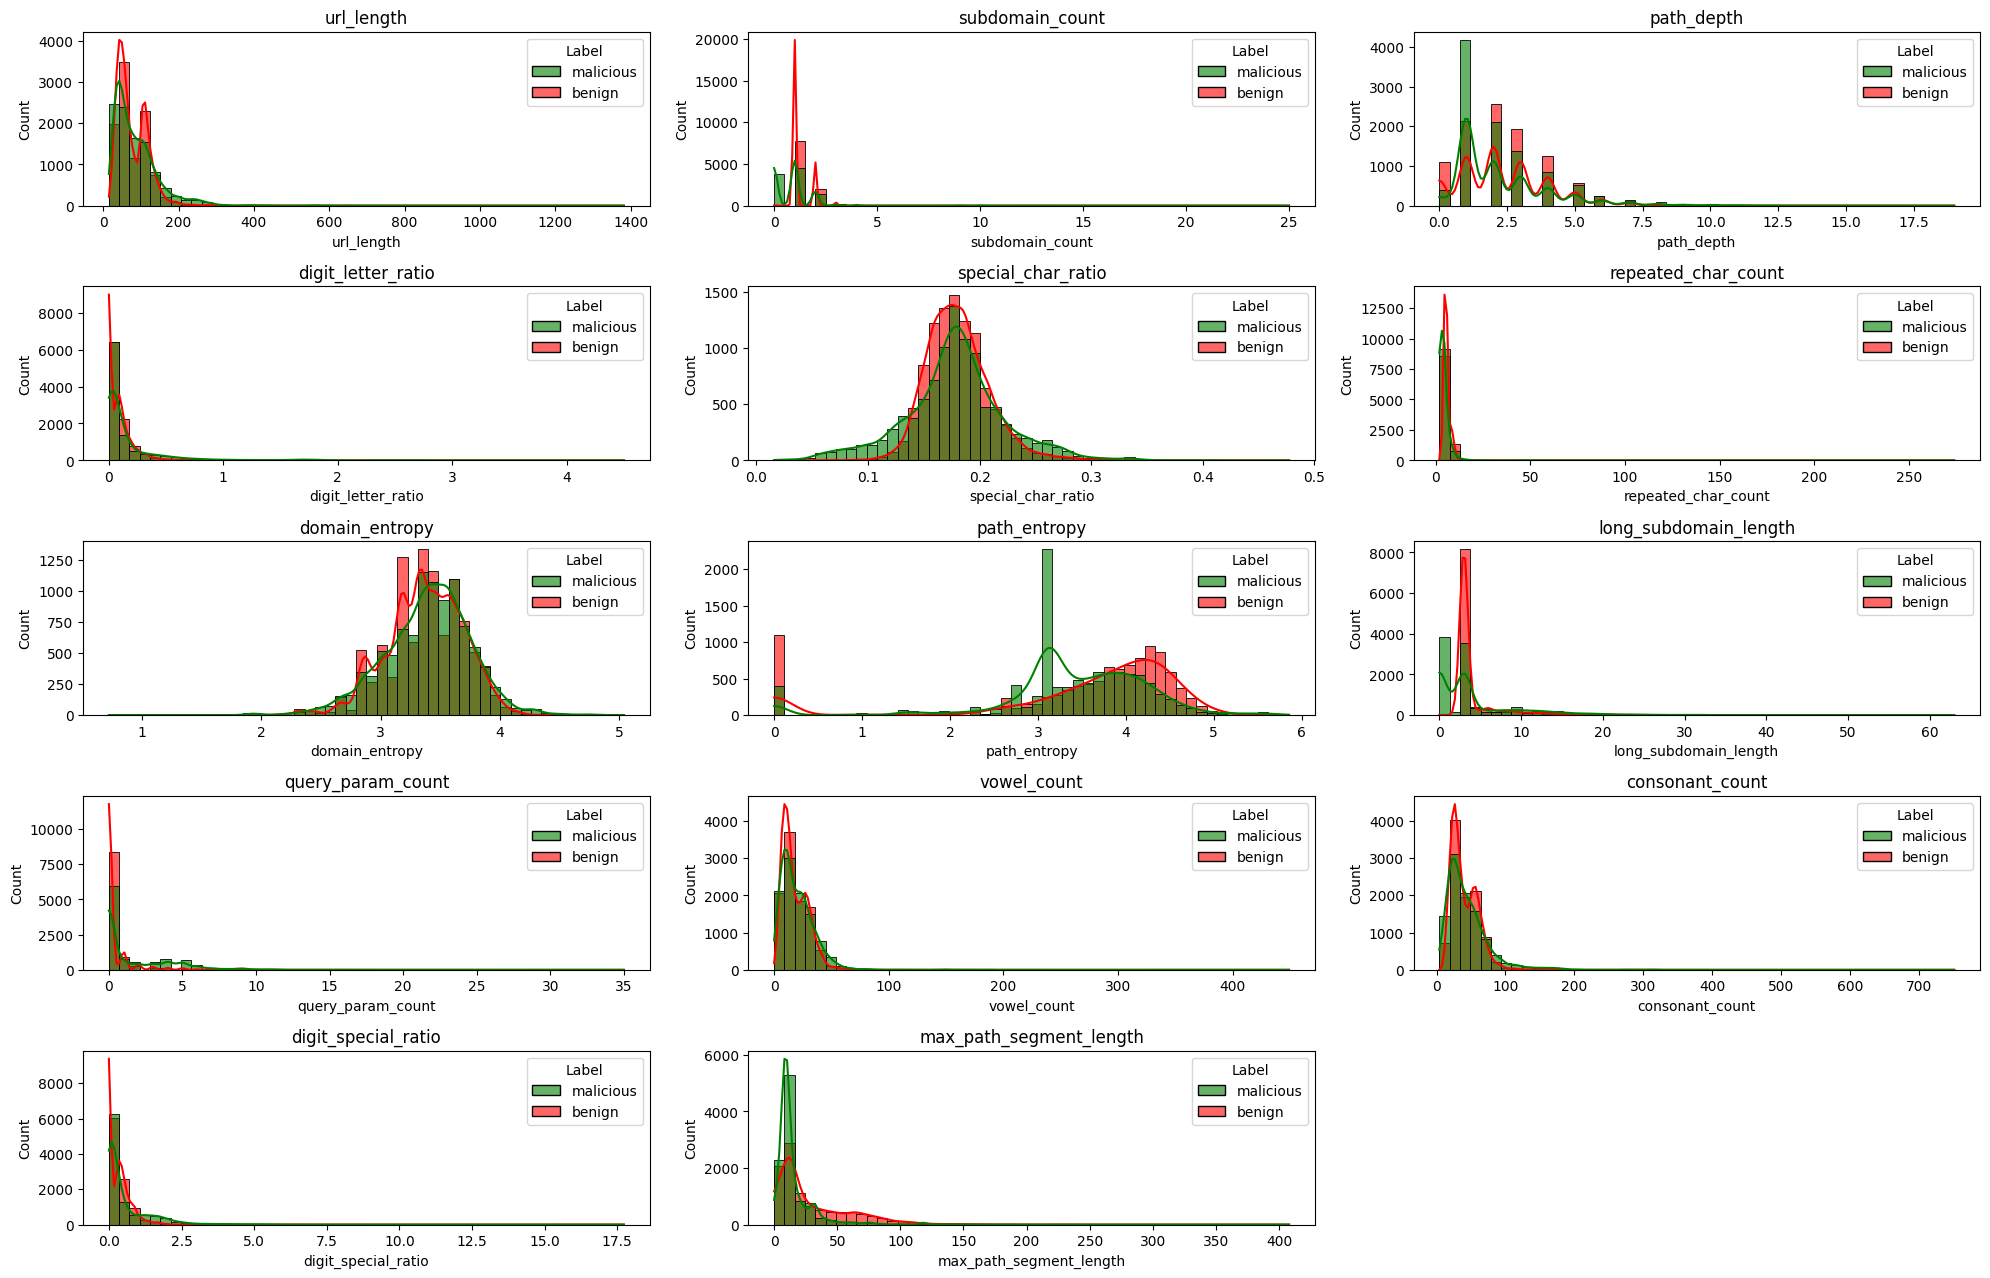

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ===============================
# Plot numeric features
# ===============================
# ===============================
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features):
    plt.subplot(6, 3, i+1)  # 6 rows x 3 cols grid is fine for 17 features
    if df[feature].nunique() > 1:
        sns.histplot(data=df, x=feature, hue='Label', bins=50, kde=True, palette=['green','red'], alpha=0.6)
    else:
        sns.histplot(data=df, x=feature, hue='Label', bins=50, palette=['green','red'])
    plt.title(feature)
plt.tight_layout()
plt.show()

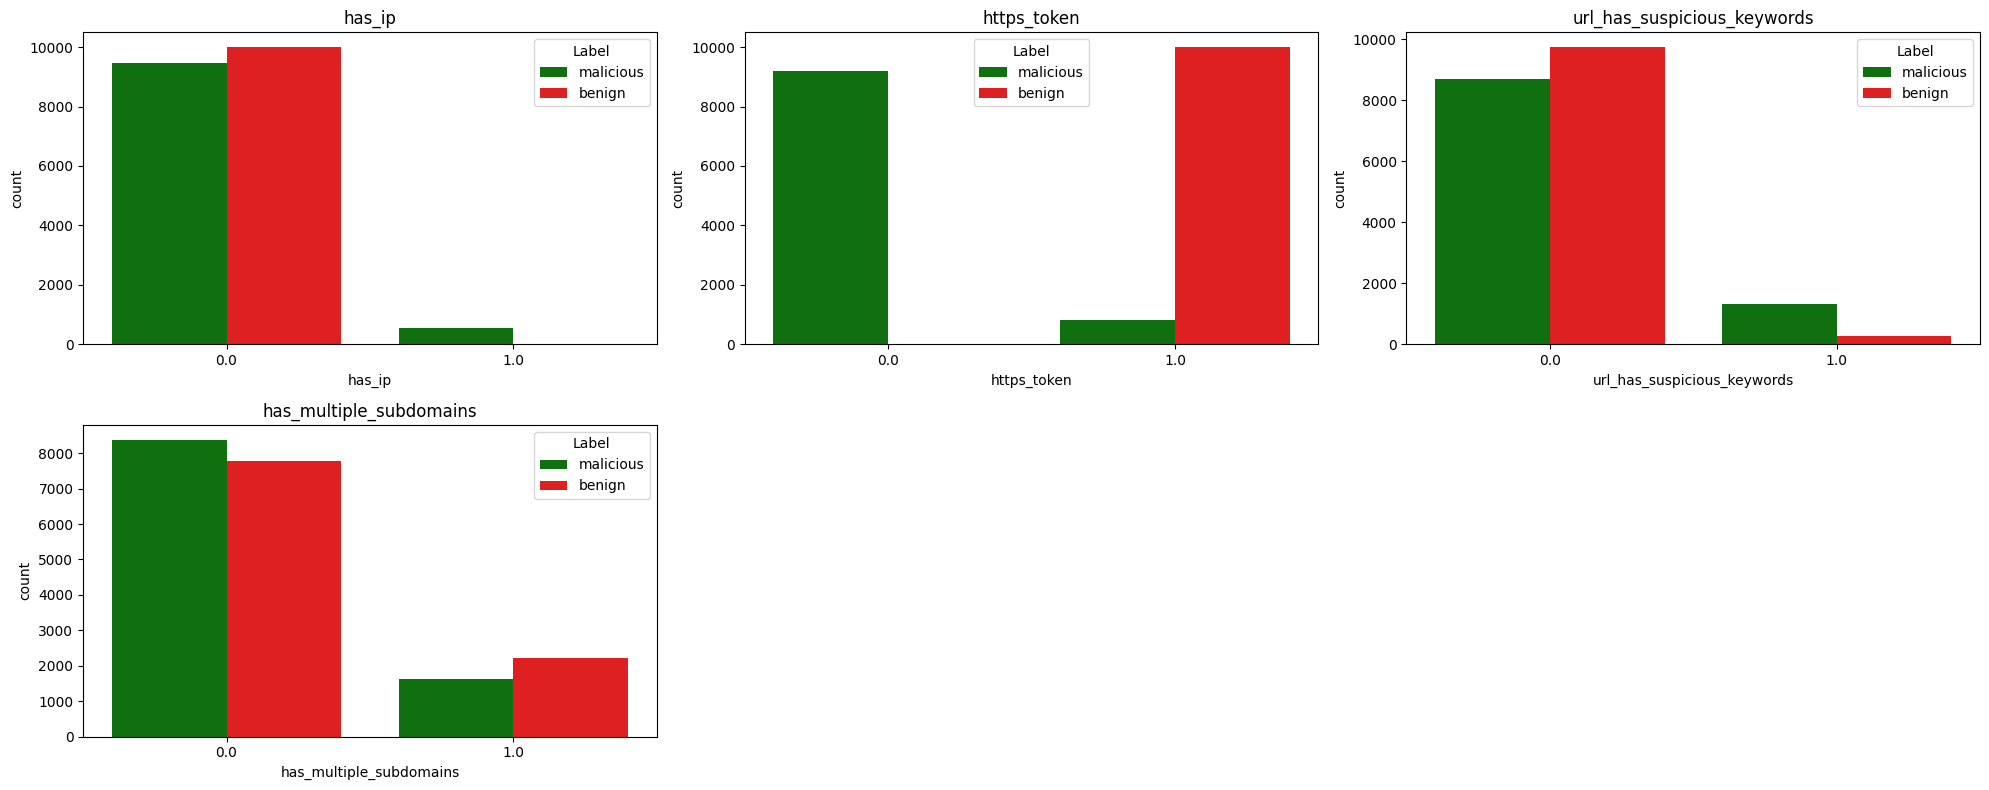

In [43]:
# ===============================
# Plot binary features
# ===============================
plt.figure(figsize=(20, 8))
for i, feature in enumerate(binary_features):
    plt.subplot(2, 3, i+1)  # adjust grid for 6 features
    sns.countplot(x=feature, hue='Label', data=df, palette=['green','red'])
    plt.title(feature)
plt.tight_layout()
plt.show()

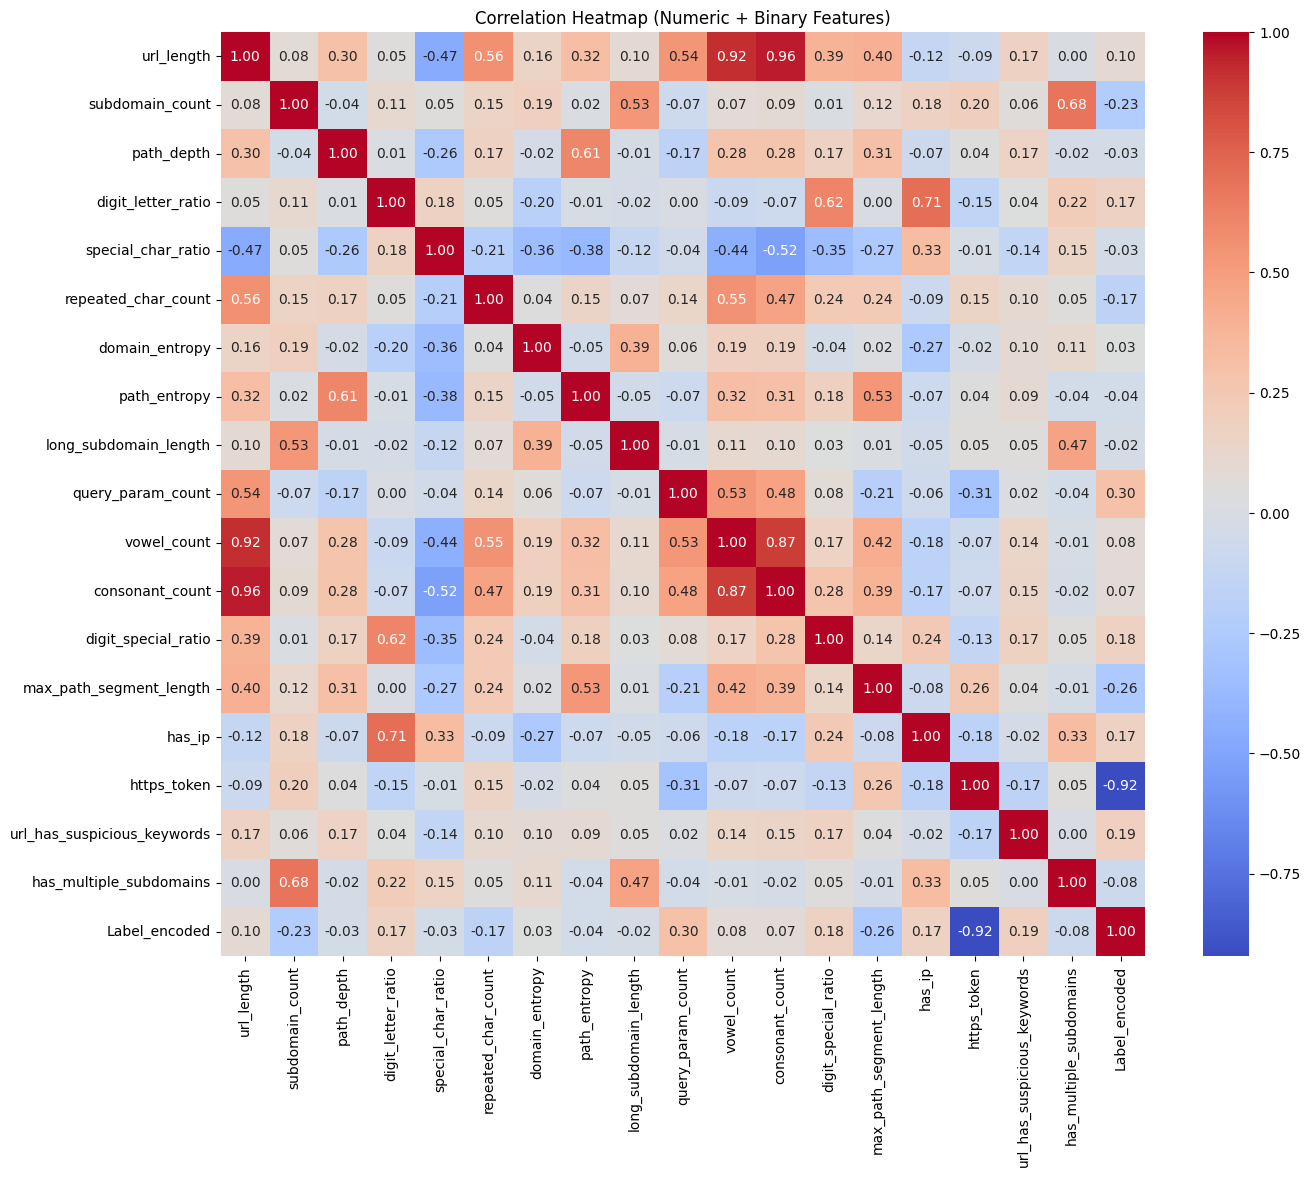

In [44]:
# ===============================
# Correlation heatmap
# ===============================
# Encode labels
df['Label_encoded'] = df['Label'].map({'benign': 0, 'malicious': 1})
plt.figure(figsize=(15, 12))
corr_matrix = df[numeric_features + binary_features + ['Label_encoded']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap (Numeric + Binary Features)")
plt.show()

CHECK FEATURES STATISTICS

In [45]:
df[numeric_features + binary_features].describe().T


,count,mean,std,min,25%,50%,75%,max
url_length,19998.0,82.224272,55.623244,15.000000,44.000000,67.000000,109.000000,1382.000000
subdomain_count,19998.0,1.047505,0.852498,0.000000,1.000000,1.000000,1.000000,25.000000
path_depth,19998.0,2.330983,1.734117,0.000000,1.000000,2.000000,3.000000,19.000000
digit_letter_ratio,19998.0,0.126492,0.274117,0.000000,0.000000,0.054054,0.130435,4.500000
special_char_ratio,19998.0,0.179168,0.037851,0.015842,0.159091,0.178218,0.200000,0.477273
repeated_char_count,19998.0,5.064906,3.432179,2.000000,4.000000,5.000000,6.000000,274.000000
domain_entropy,19998.0,3.383707,0.342507,0.721928,3.182006,3.406545,3.616349,5.040492
path_entropy,19998.0,3.440303,1.164177,-0.000000,3.121928,3.721612,4.185230,5.857382
long_subdomain_length,19998.0,4.070557,4.699381,0.000000,3.000000,3.000000,3.000000,63.000000
query_param_count,19998.0,0.979098,2.073140,0.000000,0.000000,0.000000,1.000000,35.000000
